<a href="https://colab.research.google.com/github/fmuranda/pythia-foundations/blob/main/core/xarray/enso-xarray.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Calculating ENSO with Xarray



---

## Overview

In this tutorial, we perform and demonstrate the following tasks:

1. Load SST data from the CESM2 model
2. Mask data using `.where()`
3. Compute climatologies and anomalies using `.groupby()`
4. Use `.rolling()` to compute moving average
5. Compute, normalize, and plot the Niño 3.4 Index

## Prerequisites


| Concepts | Importance | Notes |
| --- | --- | --- |
| [Introduction to Xarray](xarray-intro) | Necessary | {cite:t}`hoyer2017xarray` |
| [Computation and Masking](computation-masking) | Necessary | |



- **Time to learn**: 20 minutes

---

## Imports

For this tutorial, we import several Python packages. As plotting ENSO data requires a geographically accurate map, Cartopy is imported to handle geographic features and map projections. Xarray is used to manage raw data, and Matplotlib allows for feature-rich data plotting. Finally, a custom Pythia package is imported, in this case allowing access to the Pythia example data library.

In [2]:
!pip install cartopy
import cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 59.2 MB/s eta 0:00:00


In [7]:
!pip install pythia-datasets cftime
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import xarray as xr
from pythia_datasets import DATASETS

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 56.2 MB/s eta 0:00:00


## The Niño 3.4 Index


In this tutorial, we combine topics covered in previous Xarray tutorials to demonstrate a real-world example. The real-world scenario demonstrated in this tutorial is the computation of the [Niño 3.4 Index](https://climatedataguide.ucar.edu/climate-data/nino-sst-indices-nino-12-3-34-4-oni-and-tni), as shown in the CESM2 submission for the [CMIP6 project](https://esgf-node.llnl.gov/projects/cmip6/). A rough definition of Niño 3.4, in addition to a definition of Niño data computation, is listed below:

> Niño 3.4 (5N-5S, 170W-120W): The Niño 3.4 anomalies may be thought of as representing the average equatorial SSTs across the Pacific from about the dateline to the South American coast. The Niño 3.4 index typically uses a 5-month running mean, and El Niño or La Niña events are defined when the Niño 3.4 SSTs exceed +/- 0.4C for a period of six months or more.

> Niño X Index computation: a) Compute area averaged total SST from Niño X region; b) Compute monthly climatology (e.g., 1950-1979) for area averaged total SST from Niño X region, and subtract climatology from area averaged total SST time series to obtain anomalies; c) Smooth the anomalies with a 5-month running mean; d) Normalize the smoothed values by its standard deviation over the climatological period.

![](https://www.ncdc.noaa.gov/monitoring-content/teleconnections/nino-regions.gif)

The overall goal of this tutorial is to produce a plot of ENSO data using Xarray; this plot will resemble the Oceanic Niño Index plot shown below.

![ONI index plot from NCAR Climate Data Guide](https://climatedataguide.ucar.edu/sites/default/files/styles/extra_large/public/2022-03/indices_oni_2_2_lg.png)

In this first example, we begin by opening datasets containing the sea-surface temperature (SST) and grid-cell size data. (These datasets are taken from the Pythia example data library, using the Pythia package imported above.) The two datasets are then combined into a single dataset using Xarray's `merge` method.

In [8]:
filepath = DATASETS.fetch('CESM2_sst_data.nc')
data = xr.open_dataset(filepath)
filepath2 = DATASETS.fetch('CESM2_grid_variables.nc')
areacello = xr.open_dataset(filepath2).areacello

ds = xr.merge([data, areacello])
ds

/usr/local/lib/python3.12/dist-packages/xarray/conventions.py:204: SerializationWarning: variable 'tos' has multiple fill values {np.float32(1e+20), np.float64(1e+20)} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)


<xarray.Dataset> Size: 47MB
Dimensions:    (time: 180, d2: 2, lat: 180, lon: 360)
Coordinates:
  * time       (time) object 1kB 2000-01-15 12:00:00 ... 2014-12-15 12:00:00
  * lat        (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon        (lon) float64 3kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
Dimensions without coordinates: d2
Data variables:
    time_bnds  (time, d2) object 3kB ...
    lat_bnds   (lat, d2) float64 3kB ...
    lon_bnds   (lon, d2) float64 6kB ...
    tos        (time, lat, lon) float32 47MB ...
    areacello  (lat, lon) float64 518kB ...
Attributes: (12/45)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   674885.0
    branch_time_in_parent:  219000.0
    case_id:                972
    ...                     ...
    sub_experiment_id:      none
    table_id:               Omon
    tracking_id:            hdl:21.14100/2975ffd3-1d7b-47e3-961a-33f212ea4eb2
    variable_id:            tos
    variant_info:           CMIP6 20th century experiments (1850-2014) with C...
    variant_label:          r11i1p1f1

This example uses Matplotlib and Cartopy to plot the first time slice of the dataset on an actual geographic map. By doing so, we verify that the data values fit the pattern of SST data:

/usr/local/lib/python3.12/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


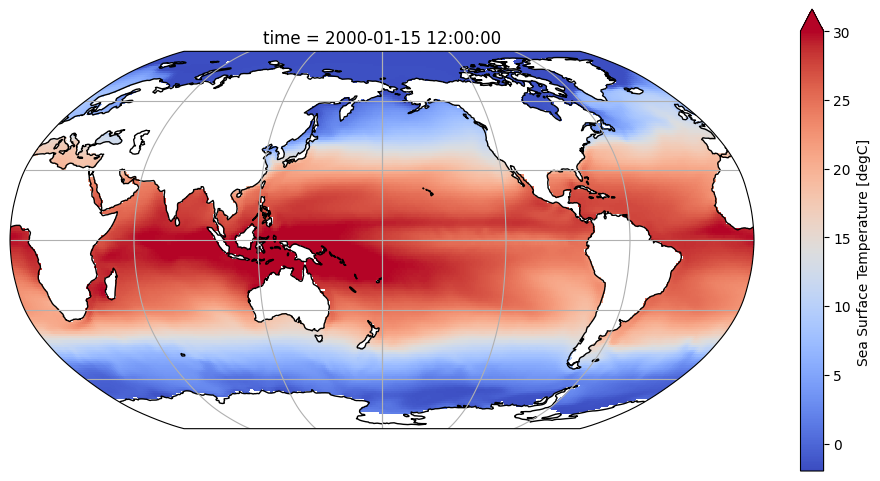

In [9]:
fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.Robinson(central_longitude=180))
ax.coastlines()
ax.gridlines()
ds.tos.isel(time=0).plot(
    ax=ax, transform=ccrs.PlateCarree(), vmin=-2, vmax=30, cmap='coolwarm'
);

## Select the Niño 3.4 region

In this set of examples, we demonstrate the selection of data values from a dataset which are located in the Niño 3.4 geographic region. The following example illustrates a selection technique that uses the `sel()` or `isel()` method:

In [10]:
tos_nino34 = ds.sel(lat=slice(-5, 5), lon=slice(190, 240))
tos_nino34

<xarray.Dataset> Size: 370kB
Dimensions:    (time: 180, d2: 2, lat: 10, lon: 50)
Coordinates:
  * time       (time) object 1kB 2000-01-15 12:00:00 ... 2014-12-15 12:00:00
  * lat        (lat) float64 80B -4.5 -3.5 -2.5 -1.5 -0.5 0.5 1.5 2.5 3.5 4.5
  * lon        (lon) float64 400B 190.5 191.5 192.5 193.5 ... 237.5 238.5 239.5
Dimensions without coordinates: d2
Data variables:
    time_bnds  (time, d2) object 3kB ...
    lat_bnds   (lat, d2) float64 160B ...
    lon_bnds   (lon, d2) float64 800B ...
    tos        (time, lat, lon) float32 360kB ...
    areacello  (lat, lon) float64 4kB ...
Attributes: (12/45)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   674885.0
    branch_time_in_parent:  219000.0
    case_id:                972
    ...                     ...
    sub_experiment_id:      none
    table_id:               Omon
    tracking_id:            hdl:21.14100/2975ffd3-1d7b-47e3-961a-33f212ea4eb2
    variable_id:            tos
    variant_info:           CMIP6 20th century experiments (1850-2014) with C...
    variant_label:          r11i1p1f1

This example illustrates the alternate technique for selecting Niño 3.4 data, which makes use of the `where()` method:

In [11]:
tos_nino34 = ds.where(
    (ds.lat < 5) & (ds.lat > -5) & (ds.lon > 190) & (ds.lon < 240), drop=True
)
tos_nino34

<xarray.Dataset> Size: 2MB
Dimensions:    (time: 180, d2: 2, lat: 10, lon: 50)
Coordinates:
  * time       (time) object 1kB 2000-01-15 12:00:00 ... 2014-12-15 12:00:00
  * lat        (lat) float64 80B -4.5 -3.5 -2.5 -1.5 -0.5 0.5 1.5 2.5 3.5 4.5
  * lon        (lon) float64 400B 190.5 191.5 192.5 193.5 ... 237.5 238.5 239.5
Dimensions without coordinates: d2
Data variables:
    time_bnds  (time, d2, lat, lon) object 1MB 2000-01-01 00:00:00 ... 2015-0...
    lat_bnds   (lat, d2, lon) float64 8kB -5.0 -5.0 -5.0 -5.0 ... 5.0 5.0 5.0
    lon_bnds   (lon, d2, lat) float64 8kB 190.0 190.0 190.0 ... 240.0 240.0
    tos        (time, lat, lon) float32 360kB 28.26 28.16 28.06 ... 28.57 28.63
    areacello  (lat, lon) float64 4kB 1.233e+10 1.233e+10 ... 1.233e+10
Attributes: (12/45)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   674885.0
    branch_time_in_parent:  219000.0
    case_id:                972
    ...                     ...
    sub_experiment_id:      none
    table_id:               Omon
    tracking_id:            hdl:21.14100/2975ffd3-1d7b-47e3-961a-33f212ea4eb2
    variable_id:            tos
    variant_info:           CMIP6 20th century experiments (1850-2014) with C...
    variant_label:          r11i1p1f1

Finally, we plot the selected region to ensure it fits the definition of the Niño 3.4 region:

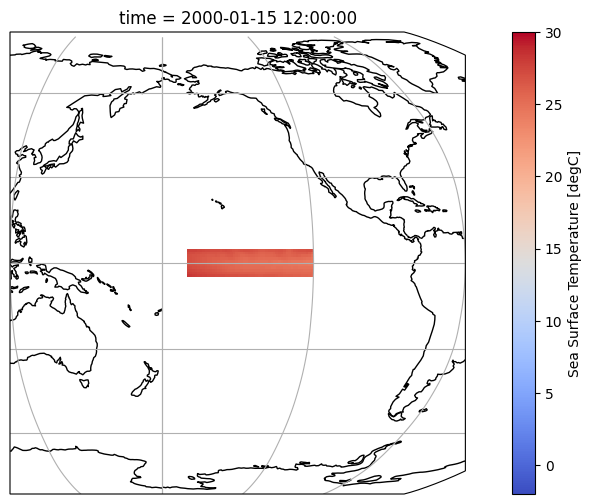

In [12]:
fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.Robinson(central_longitude=180))
ax.coastlines()
ax.gridlines()
tos_nino34.tos.isel(time=0).plot(
    ax=ax, transform=ccrs.PlateCarree(), vmin=-2, vmax=30, cmap='coolwarm'
)
ax.set_extent((120, 300, 10, -10))

## Compute the anomalies

There are three main steps to obtain the anomalies from the Niño 3.4 dataset created in the previous set of examples. First, we use the `groupby()` method to convert to monthly data. Second, we subtract the mean sea-surface temperature (SST) from the monthly data. Finally, we obtain the anomalies by computing a weighted average. These steps are illustrated in the next example:

In [17]:
import numpy as np
tos_nino34 = xr.decode_cf(tos_nino34)
# Manually extract month to avoid IndexVariable attribute issues
months = xr.DataArray([t.month for t in tos_nino34.time.values], coords=[tos_nino34.time], name='month')
gb = tos_nino34.tos.groupby(months)
tos_nino34_anom = gb - gb.mean(dim='time')
index_nino34 = tos_nino34_anom.weighted(tos_nino34.areacello).mean(dim=['lat', 'lon'])

In this example, we smooth the data curve by applying a `mean` function with a 5-month moving window to the anomaly dataset. We then plot the smoothed data against the original data to demonstrate:

In [18]:
index_nino34_rolling_mean = index_nino34.rolling(time=5, center=True).mean()

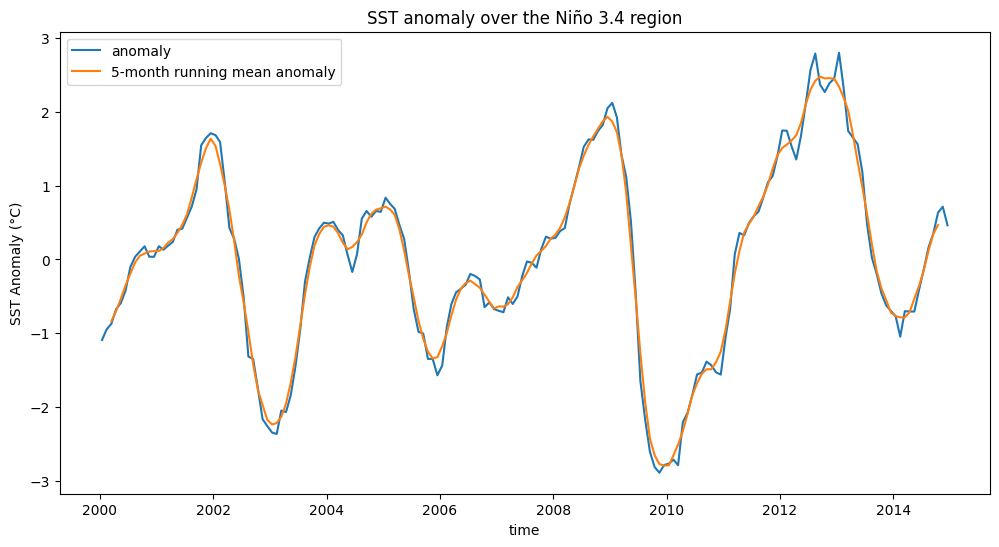

In [27]:
import pandas as pd

# Ensure the time coordinate is properly set and convert to standard pandas datetime
index_nino34.coords['time'] = tos_nino34.time.values
index_nino34_rolling_mean.coords['time'] = tos_nino34.time.values

# Convert the coordinate to a pandas DatetimeIndex (using the 1D values)
# For cftime, we convert to a numeric/datetime format matplotlib understands
time_plot = pd.to_datetime([str(t) for t in tos_nino34.time.values])

plt.figure(figsize=(12, 6))
plt.plot(time_plot, index_nino34.values, label='anomaly')
plt.plot(time_plot, index_nino34_rolling_mean.values, label='5-month running mean anomaly')

plt.legend()
plt.title('SST anomaly over the Niño 3.4 region')
plt.xlabel('time')
plt.ylabel('SST Anomaly (°C)');

Since the ENSO index conveys deviations from a norm, the calculation of Niño data requires a standard deviation. In this example, we calculate the standard deviation of the SST in the Niño 3.4 region data, across the entire time period of the data array:

In [28]:
std_dev = tos_nino34.tos.std()
std_dev

<xarray.DataArray 'tos' ()> Size: 8B
array(1.84363365)
Attributes: (12/19)
    cell_measures:  area: areacello
    cell_methods:   area: mean where sea time: mean
    comment:        Model data on the 1x1 grid includes values in all cells f...
    description:    This may differ from "surface temperature" in regions of ...
    frequency:      mon
    id:             tos
    ...             ...
    time_label:     time-mean
    time_title:     Temporal mean
    title:          Sea Surface Temperature
    type:           real
    units:          degC
    variable_id:    tos

The final step of the Niño 3.4 index calculation involves normalizing the data. In this example, we perform this normalization by dividing the smoothed anomaly data by the standard deviation calculated above:

In [29]:
normalized_index_nino34_rolling_mean = index_nino34_rolling_mean / std_dev

## Visualize the computed Niño 3.4 index

In this example, we use Matplotlib to generate a plot of our final Niño 3.4 data. This plot is set up to highlight values above 0.5, corresponding to El Niño (warm) events, and values below -0.5, corresponding to La Niña (cold) events.

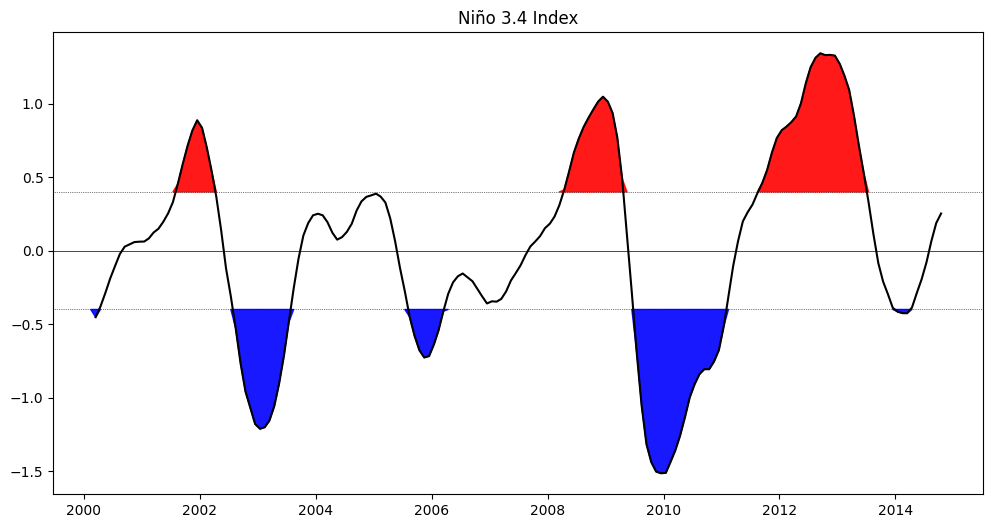

In [31]:
import pandas as pd
import numpy as np

# Convert cftime to standard dates that matplotlib fill_between can handle
time_plot = pd.to_datetime([str(t) for t in normalized_index_nino34_rolling_mean.time.values])
data_values = normalized_index_nino34_rolling_mean.data

fig = plt.figure(figsize=(12, 6))

# Fill El Niño (warm) events
plt.fill_between(
    time_plot,
    np.where(data_values >= 0.4, data_values, 0.4),
    0.4,
    where=(data_values >= 0.4),
    color='red',
    alpha=0.9,
    interpolate=True
)

# Fill La Niña (cold) events
plt.fill_between(
    time_plot,
    np.where(data_values <= -0.4, data_values, -0.4),
    -0.4,
    where=(data_values <= -0.4),
    color='blue',
    alpha=0.9,
    interpolate=True
)

plt.plot(time_plot, data_values, color='black')
plt.axhline(0, color='black', lw=0.5)
plt.axhline(0.4, color='black', linewidth=0.5, linestyle='dotted')
plt.axhline(-0.4, color='black', linewidth=0.5, linestyle='dotted')
plt.title('Niño 3.4 Index');

---

## Summary

This tutorial covered the use of Xarray features, including selection, grouping, and statistical functions, to compute and visualize a data index important to climate science.

## Additional Resources

- [Niño 3.4 index](https://climatedataguide.ucar.edu/climate-data/nino-sst-indices-nino-12-3-34-4-oni-and-tni)
- [Matplotlib's `fill_between` method](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.fill_between.html)
- [Matplotlib's `axhline` method](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.axhline.html) (see also its analogous `axvline` method)
